# Baseline Models

## Plan
- Build a leakage-safe chronological split **before** any encoding
- Fit `FeaturePipeline` only on the train split, then reuse it to transform val/test
- Train a few baselines (CatBoost (my encoding and cat encoding), LGBM, XGB) with class weights and pick by PR AUC
- Feature selection for adding it in business logic
- Fine tuning models by optuna and tune threshold

In [579]:
import logging
import os
from pathlib import Path
from dotenv import load_dotenv

import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch, Rectangle
import seaborn as sns

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.inspection import permutation_importance
import shap

from aml.pipelines.feature_pipeline import FeaturePipeline
from aml.eval.time_split import chronological_split, describe_split
from aml.eval.metrics import evaluate_binary_classifier, find_best_threshold

logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s")

# Testing on a small amount of data

Load only 300 000 rows for feature selection

In [9]:
load_dotenv("../.env")
DATA_PATH = Path(os.getenv("DATA_PATH", "data")).expanduser()
CSV_PATH = DATA_PATH / "raw/AMLNet_August_2025.csv"
ROW_LIMIT = 300000
TARGET_COL = "isFraud"
SPLIT_CFG = dict(test_days=20, val_days=15, gap_days=1)
RANDOM_STATE = 42

In [5]:
raw_df = pd.read_csv(CSV_PATH, nrows=ROW_LIMIT)
target = raw_df[TARGET_COL]
raw_df = FeaturePipeline(enable_columns=True, enable_encoding=False).fit_transform(raw_df, target)
raw_df[TARGET_COL] = target

print(f"Shape: {raw_df.shape}")
print(raw_df[[TARGET_COL]].describe())
print(f"Positive rate: {raw_df[TARGET_COL].mean():.6f}")

2025-12-12 19:38:41,811 | INFO | FeaturePipeline initialized | downcasting=True | encoding=False | _scale=False | columns=True
2025-12-12 19:38:41,811 | INFO | ▶ fit_transform | in_shape=(300000, 17)
2025-12-12 19:38:41,811 | INFO | Input validated | shape=(300000, 17)
2025-12-12 19:38:41,812 | INFO | ▶ build_features | in_shape=(300000, 17)
2025-12-12 19:38:41,819 | WARNING | Dropping potential leakage columns: ['fraud_probability', 'laundering_typology', 'isFraud', 'isMoneyLaundering']
2025-12-12 19:38:56,918 | INFO | ▶ feature_engineering | in_shape=(300000, 31)
2025-12-12 19:38:56,929 | INFO | ✓ feature_engineering | out_shape=(300000, 38) | 0.011s
2025-12-12 19:38:56,929 | INFO | ▶ finalize | in_shape=(300000, 38)
2025-12-12 19:38:57,004 | INFO | ✓ finalize | out_shape=(300000, 38) | 0.075s
2025-12-12 19:38:57,018 | INFO | ✓ build_features | out_shape=(300000, 38) | 15.206s
2025-12-12 19:38:57,018 | INFO | ✓ fit_transform | out_shape=(300000, 38) | 15.207s


Shape: (300000, 39)
             isFraud
count  300000.000000
mean        0.001603
std         0.040010
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Positive rate: 0.001603


## Leakage-safe chronological split
Split by time **before** fitting encoders to avoid leaking label information via target encoding or imputers.

In [ ]:
split = chronological_split(raw_df, timestamp_col="timestamp_ts", **SPLIT_CFG)
stats = describe_split(split, target=TARGET_COL)
print(stats)

train_df = split. val.sort_values("timestamp_ts").reset_index(drop=True)
val_df = split.val.sort_values("timestamp_ts").reset_index(drop=True)
test_df = split.test.sort_values("timestamp_ts").reset_index(drop=True)

print({k: v.shape for k, v in {" val": train_df, "val": val_df, "test": test_df}.items()})

{'train_n': 137738, 'train_pos': 239, 'train_pos_rate': 0.001735178382145813, 'val_n': 84187, 'val_pos': 139, 'val_pos_rate': 0.0016510862722273036, 'test_n': 65028, 'test_pos': 86, 'test_pos_rate': 0.001322507227655779}
{'train': (137738, 39), 'val': (84187, 39), 'test': (65028, 39)}


## Feature pipeline (fit on train only)

In [ ]:
pipe = FeaturePipeline(enable_encoding=True, enable_columns=True)

X_train = pipe.fit_transform(train_df, train_df[TARGET_COL])
X_val = pipe.transform(val_df)
X_test = pipe.transform(test_df)

y_train = train_df[TARGET_COL].to_numpy()
y_val = val_df[TARGET_COL].to_numpy()
y_test = test_df[TARGET_COL].to_numpy()

print("Shapes | train/val/test:", X_train.shape, X_val.shape, X_test.shape)
print(f"Train positive rate: {y_train.mean():.6f}")

2025-12-12 19:50:27,035 | INFO | FeaturePipeline initialized | downcasting=True | encoding=True | _scale=False | columns=True
2025-12-12 19:50:27,036 | INFO | ▶ fit_transform | in_shape=(137738, 39)
2025-12-12 19:50:27,036 | INFO | Input validated | shape=(137738, 39)
2025-12-12 19:50:27,036 | INFO | ▶ build_features | in_shape=(137738, 39)
2025-12-12 19:50:27,044 | WARNING | Dropping potential leakage columns: ['isFraud']
2025-12-12 19:50:27,120 | INFO | ▶ feature_engineering | in_shape=(137738, 38)
2025-12-12 19:50:27,123 | INFO | ✓ feature_engineering | out_shape=(137738, 38) | 0.003s
2025-12-12 19:50:27,123 | INFO | ▶ finalize | in_shape=(137738, 38)
2025-12-12 19:50:27,154 | INFO | ✓ finalize | out_shape=(137738, 38) | 0.031s
2025-12-12 19:50:27,155 | INFO | ✓ build_features | out_shape=(137738, 38) | 0.119s
2025-12-12 19:50:27,156 | INFO | ▶ fit_encoder | in_shape=(137738, 38)
2025-12-12 19:50:29,575 | WARNING | get_feature_names_out() exists but failed, fallback to manual build


Shapes | train/val/test: (137738, 69) (84187, 69) (65028, 69)
Train positive rate: 0.001735


## CatBoost encoding vs Target encoding

In [ ]:
N_pos = (y_train == 1).sum()
N_neg = (y_train == 0).sum()

scale_pos_weight = N_neg / N_pos

In [ ]:
X_train_not_encoded = train_df.drop(columns="isFraud")
y_train_not_encoded = train_df.isFraud

X_val_not_encoded = val_df.drop(columns="isFraud")
y_val_not_encoded = val_df.isFraud

X_test_not_encoded = test_df.drop(columns="isFraud")
y_test_not_encoded = test_df.isFraud

cat = CatBoostClassifier(
    eval_metric="AUC",
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=200,
    random_state=42,
    verbose=False
)

In [ ]:
results = []
print("Fitting CAT without encoding")

cat.fit(X_train_not_encoded, y_train_not_encoded,
        eval_set=(X_val_not_encoded, y_val_not_encoded),
        cat_features=np.array(train_df.columns[(train_df.dtypes=="category") | (train_df.dtypes=="object")])
)

metrics = evaluate_binary_classifier(cat, X_test_not_encoded, y_test_not_encoded, threshold=0.5)

results.append({
    "model": "no_encoding",
    "roc_auc": metrics["roc_auc"],
    "recall_curve": metrics["recall_curve"],
    "pr_auc": metrics["pr_auc"],
    "f1_05": metrics["f1"],
})

print("Fitting CAT with encoding")

cat.fit(X_train, y_train,
        eval_set=(X_val, y_val)
)

metrics = evaluate_binary_classifier(cat, X_test, y_test, threshold=0.5)

results.append({
    "model": "is_encoding",
    "roc_auc": metrics["roc_auc"],
    "recall_curve": metrics["recall_curve"],
    "pr_auc": metrics["pr_auc"],
    "f1_05": metrics["f1"],
})

pd.DataFrame(results).sort_values("pr_auc", ascending=False)

Fitting CAT without encoding
Fitting CAT with encoding


,model,roc_auc,recall_curve,pr_auc,f1_05
1,is_encoding,0.999422,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.964345,0.803922
0,no_encoding,0.999590,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.943214,0.617100


## Model candidates 

In [801]:
base_models = {
    "xg": XGBClassifier(
        eval_metric="aucpr",
        scale_pos_weight=scale_pos_weight,
        n_jobs=-1,
        early_stopping_rounds=200,
        random_state=42,
        use_label_encoder=False,
        verbosity=0
    ),
    "cat": CatBoostClassifier(
        eval_metric="PRAUC",
        scale_pos_weight=scale_pos_weight,
        early_stopping_rounds=200,
        random_state=42,
        verbose=False
    ),
    "ligh": LGBMClassifier(
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
        verbose=-1
    ),
}

In [740]:
results = []
feature_importances = {}
fi_perm = {}
shap_df = {}

for name, model in base_models.items():
    print(f"Fitting {name.upper()}")
    fit_params = {"X":X_train,
              "y":y_train,
              "eval_set":[(X_val, y_val)]}
    
    if name == "xg":
        fit_params["verbose"] = False
    model.fit(**fit_params)

    metrics = evaluate_binary_classifier(model, X_test, y_test, threshold=0.5)
    results.append({
        "model": name,
        "roc_auc": metrics["roc_auc"],
        "recall_curve": metrics["recall_curve"],
        "pr_auc": metrics["pr_auc"],
        "f1_05": metrics["f1"],
    })

    # Feature importance
    if name == "cat":
        fi = model.get_feature_importance()
    else:
        fi = model.feature_importances_

    feature_importances[name] = (
        pd.DataFrame({
            "feature": X_train.columns,
            "importance": fi
        })
        .sort_values(by="importance", ascending=False)
        .reset_index(drop=True)
    )

    # Permutation importance 
    r = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )

    fi_perm[name] = (
        pd.DataFrame({
            "feature": X_train.columns,
            "importance": r.importances_mean
        })
        .sort_values(by="importance", ascending=False)
        .reset_index(drop=True)
    )

    # SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    shap_df[name] = pd.DataFrame(
        shap_values,
        columns=X_test.columns,
        index=X_test.index
    )


val_df = pd.DataFrame(results).sort_values("pr_auc", ascending=False).reset_index(drop=True)
val_df

Fitting CAT
Fitting LIGH


/Users/artem/Documents/Projects/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Fitting XG


,model,roc_auc,recall_curve,pr_auc,f1_05
0,ligh,0.999909,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.962621,0.910180
1,cat,0.999341,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.946600,0.925926
2,xg,0.999593,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.933484,0.892857


## Curves
PR AUC drives selection, ROC shown for context

In [75]:
def plot_feature_importance(
    fi_df,
    model_name,
    top_n=20,
    *,
    importance_col="importance",
    feature_col="feature",
    normalize="max",# "max" | "sum" | None
    show_values=True,
    flag_suspicious=True,
    suspicious_tokens=("target", "label", "fraud", "is_fraud", "isfraud", "_te", "rate", "leak", "future", "post_", "after_"),
):
    df = fi_df[[feature_col, importance_col]].copy()
    df[feature_col] = df[feature_col].astype(str)
    df[importance_col] = np.asarray(df[importance_col], dtype=float)

    # Sort + top N
    df = df.sort_values(importance_col, ascending=False, kind="mergesort").head(top_n).copy()

    # Normalize for comparability/readability
    if normalize == "max" and df[importance_col].max() > 0:
        df["imp_norm"] = df[importance_col] / df[importance_col].max()
        x_label = "Importance (normalized to max=1.0)"
    elif normalize == "sum" and df[importance_col].sum() > 0:
        df["imp_norm"] = df[importance_col] / df[importance_col].sum()
        x_label = "Importance (share of total)"
    else:
        df["imp_norm"] = df[importance_col]
        x_label = "Importance"

    # AML-friendly suspicious flagging
    def _is_suspicious(f: str) -> bool:
        s = f.lower()
        return any(tok in s for tok in suspicious_tokens)

    if flag_suspicious:
        df["suspicious"] = df[feature_col].apply(_is_suspicious)
        df["feature_disp"] = np.where(df["suspicious"], "⚠ " + df[feature_col], df[feature_col])
    else:
        df["feature_disp"] = df[feature_col]

    # Reverse for barh
    df = df.iloc[::-1].reset_index(drop=True)

    # Figure
    fig, ax = plt.subplots(figsize=(9, max(5.5, 0.30 * len(df) + 2.0)))

    # Colors: auto by matplotlib, but keep suspicious visually distinct without hard-coding palette
    # We'll use alpha difference (no explicit colors requirement mentioned here).
    alphas = np.where(df.get("suspicious", False), 0.55, 0.90)

    bars = ax.barh(df["feature_disp"], df["imp_norm"])
    for b, a in zip(bars, alphas):
        b.set_alpha(float(a))
        b.set_linewidth(0.6)
        b.set_edgecolor("black")

    # Value labels (right-aligned, outside bars when possible)
    if show_values:
        x_max = float(df["imp_norm"].max()) if len(df) else 1.0
        pad = 0.01 * x_max
        for y, (v, raw) in enumerate(zip(df["imp_norm"].values, df[importance_col].values)):
            ax.text(
                v + pad,
                y,
                f"{raw:.4g}",
                va="center",
                ha="left",
                fontsize=9,
                clip_on=False,
            )
        ax.set_xlim(0, x_max * 1.15)

    # Styling
    ax.set_title(f"Feature Importance — {model_name} (Top {top_n})", pad=12, fontweight="bold")
    ax.set_xlabel(x_label)
    ax.set_ylabel("Feature")
    ax.grid(axis="x", linestyle="--", alpha=0.4)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Footer note if suspicious exist
    if flag_suspicious and "suspicious" in df.columns and df["suspicious"].any():
        ax.text(
            0.0,
            -0.12,
            "⚠ flagged as potentially leakage/target-proxy/TE-like — verify feature generation & split integrity",
            transform=ax.transAxes,
            fontsize=9,
            alpha=0.85,
        )

    plt.tight_layout()
    plt.show()

def plot_permutation_importance_all(
    fi_perm_dict,
    top_n=20,
    normalize="max",   # "max" | "sum" | None
):
    for model_name, df in fi_perm_dict.items():
        d = df.sort_values("importance", ascending=False).head(top_n).copy()

        if normalize == "max" and d["importance"].max() > 0:
            d["imp"] = d["importance"] / d["importance"].max()
            xlabel = "Importance (normalized)"
        elif normalize == "sum" and d["importance"].sum() > 0:
            d["imp"] = d["importance"] / d["importance"].sum()
            xlabel = "Importance (share)"
        else:
            d["imp"] = d["importance"]
            xlabel = "Importance (drop in metric)"

        d = d.iloc[::-1]

        fig, ax = plt.subplots(figsize=(9, max(5, 0.28 * len(d) + 2)))

        bars = ax.barh(d["feature"], d["imp"], alpha=0.85)
        for b in bars:
            b.set_edgecolor("black")
            b.set_linewidth(0.5)

        ax.set_title(f"Permutation Importance — {model_name}", pad=10, fontweight="bold")
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Feature")
        ax.grid(axis="x", linestyle="--", alpha=0.4)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        plt.tight_layout()
        plt.show()

def compute_shap_global_importance(shap_df):
    return (
        pd.DataFrame({
            "feature": shap_df.columns,
            "importance": np.abs(shap_df).mean(axis=0),
        })
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )


def plot_shap_global_importance_all(
    shap_df_dict,
    top_n=20,
    normalize="max",
):
    for model_name, shap_df in shap_df_dict.items():
        d = compute_shap_global_importance(shap_df).head(top_n).copy()

        if normalize == "max" and d["importance"].max() > 0:
            d["imp"] = d["importance"] / d["importance"].max()
            xlabel = "Mean |SHAP| (normalized)"
        else:
            d["imp"] = d["importance"]
            xlabel = "Mean |SHAP value|"

        d = d.iloc[::-1]

        fig, ax = plt.subplots(figsize=(9, max(5, 0.28 * len(d) + 2)))

        bars = ax.barh(d["feature"], d["imp"], alpha=0.9)
        for b in bars:
            b.set_edgecolor("black")
            b.set_linewidth(0.5)

        ax.set_title(f"SHAP Global Importance — {model_name}", pad=10, fontweight="bold")
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Feature")
        ax.grid(axis="x", linestyle="--", alpha=0.4)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        plt.tight_layout()
        plt.show()

def plot_shap_top_feature_all(
    shap_df_dict,
    X,
    sample_size=5000,   # чтобы scatter не был «шумным»
):
    for model_name, shap_df in shap_df_dict.items():
        shap_imp = compute_shap_global_importance(shap_df)
        top_feature = shap_imp.loc[0, "feature"]

        # downsample для читаемости
        if len(X) > sample_size:
            idx = np.random.choice(len(X), sample_size, replace=False)
            x_vals = X.iloc[idx][top_feature]
            shap_vals = shap_df.iloc[idx][top_feature]
        else:
            x_vals = X[top_feature]
            shap_vals = shap_df[top_feature]

        fig, ax = plt.subplots(figsize=(6.5, 5))

        ax.scatter(
            x_vals,
            shap_vals,
            alpha=0.4,
            s=18,
            edgecolor="none",
        )

        ax.axhline(0, color="gray", linestyle="--", linewidth=1)

        ax.set_title(
            f"SHAP Dependence — {model_name}\nFeature: {top_feature}",
            pad=10,
            fontweight="bold",
        )
        ax.set_xlabel(f"{top_feature} value")
        ax.set_ylabel("SHAP value")
        ax.grid(True, linestyle="--", alpha=0.4)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        plt.tight_layout()
        plt.show()


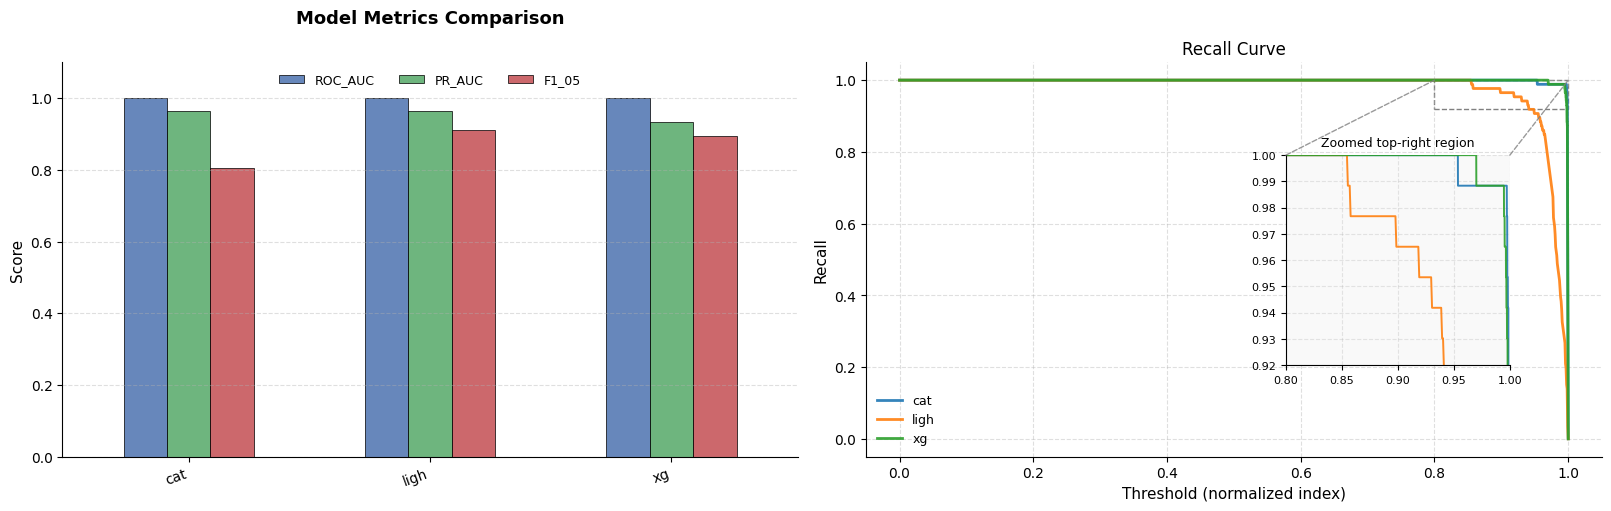

In [730]:
# Base config
plt.rcParams.update({
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 9,
})

fig, axes = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)

models = val_df["model"].values
metrics = ["roc_auc", "pr_auc", "f1_05"]
 
# LEFT — Metrics Barplot
ax1 = axes[0]

x = np.arange(len(models))
width = 0.18

colors = {
    "roc_auc": "#4C72B0",
    "pr_auc": "#55A868",
    "f1_05": "#C44E52",
}

for i, metric in enumerate(metrics):
    ax1.bar(
        x + (i - 1) * width,
        val_df[metric].values,
        width=width,
        label=metric.upper(),
        linewidth=0.6,
        edgecolor="black",
        alpha=0.85,
        color=colors.get(metric),
    )

ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=20, ha="right", fontsize=10)

ax1.margins(x=0.1)

ax1.set_title(
    "Model Metrics Comparison",
    pad=28,
    fontsize=13,
    fontweight="bold"
)

y_min, y_max = ax1.get_ylim()
ax1.set_ylim(0, y_max + 0.05)

ax1.set_ylabel("Score")
ax1.legend(frameon=False, ncol=3, loc="upper center")
ax1.grid(axis="y", linestyle="--", alpha=0.4)


# RIGHT — Recall Curve
ax2 = axes[1]

for _, row in val_df.iterrows():
    recall_curve = np.array(row["recall_curve"])
    x_vals = np.linspace(0, 1, len(recall_curve))
    ax2.plot(
        x_vals,
        recall_curve,
        label=row["model"],
        linewidth=2,
        alpha=0.9,
    )

ax2.set_xlabel("Threshold (normalized index)")
ax2.set_ylabel("Recall")
ax2.set_title("Recall Curve")
ax2.grid(True, linestyle="--", alpha=0.4)
ax2.legend(frameon=False, loc="lower left")

x1_min, x1_max = 0.8, 1.0
y1_min, y1_max = 0.92, 1.00

zoom_rect = Rectangle(
    (x1_min, y1_min),
    x1_max - x1_min,
    y1_max - y1_min,
    linewidth=1,
    edgecolor="gray",
    linestyle="--",
    facecolor="none",
)
ax2.add_patch(zoom_rect)


# OUTSIDE-INSET
zoom_ax = fig.add_axes([0.80, 0.28, 0.14, 0.42])
zoom_ax.set_facecolor("#f9f9f9")

for _, row in val_df.iterrows():
    recall_curve = np.array(row["recall_curve"])
    x_vals = np.linspace(0, 1, len(recall_curve))
    zoom_ax.plot(
        x_vals,
        recall_curve,
        linewidth=1.4,
        alpha=0.9,
    )

zoom_ax.set_xlim(x1_min, x1_max)
zoom_ax.set_ylim(y1_min, y1_max)
zoom_ax.grid(True, linestyle="--", alpha=0.3)
zoom_ax.set_title("Zoomed top-right region", fontsize=9)
zoom_ax.tick_params(labelsize=8)


# CONNECTOR LINES
corners_main = [
    (x1_min, y1_max),
    (x1_max, y1_max),
]

corners_zoom = [
    (x1_min, y1_max),
    (x1_max, y1_max),
]

for (xm, ym), (xz, yz) in zip(corners_main, corners_zoom):
    con = ConnectionPatch(
        xyA=(xz, yz), coordsA=zoom_ax.transData,
        xyB=(xm, ym), coordsB=ax2.transData,
        arrowstyle="-",
        linestyle="--",
        color="gray",
        linewidth=1,
        alpha=0.8,
    )
    fig.add_artist(con)

plt.show()

## Feature importance

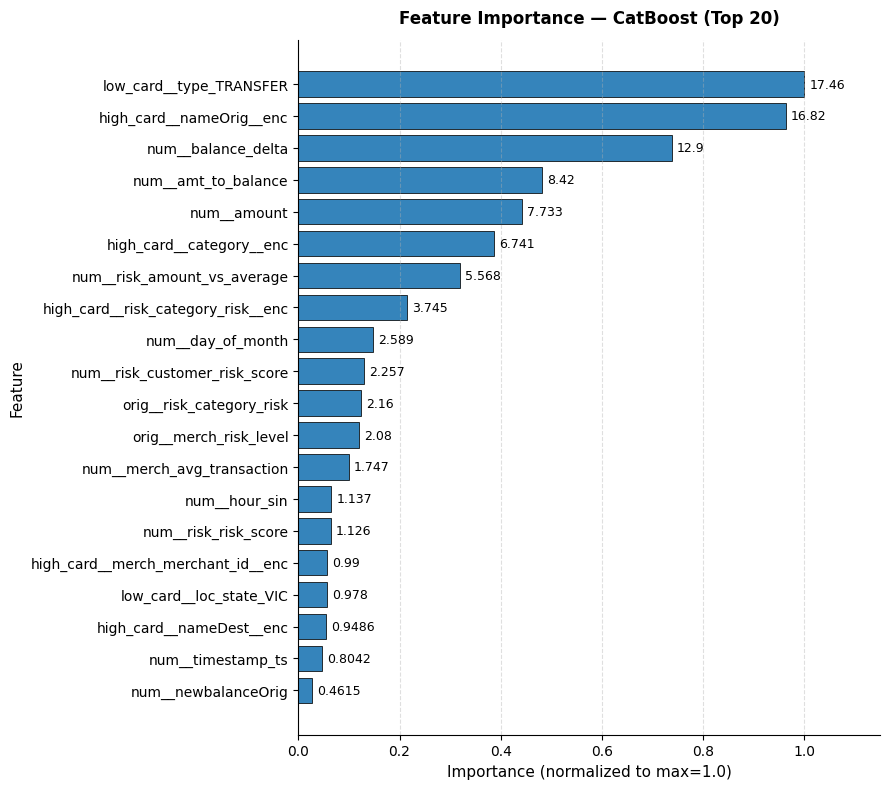

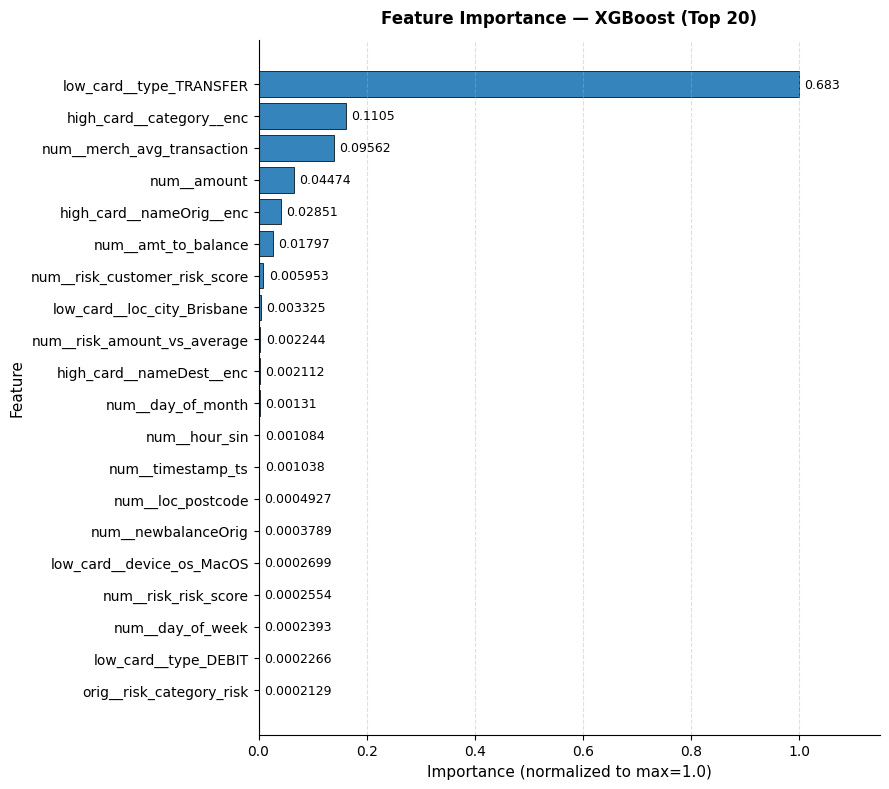

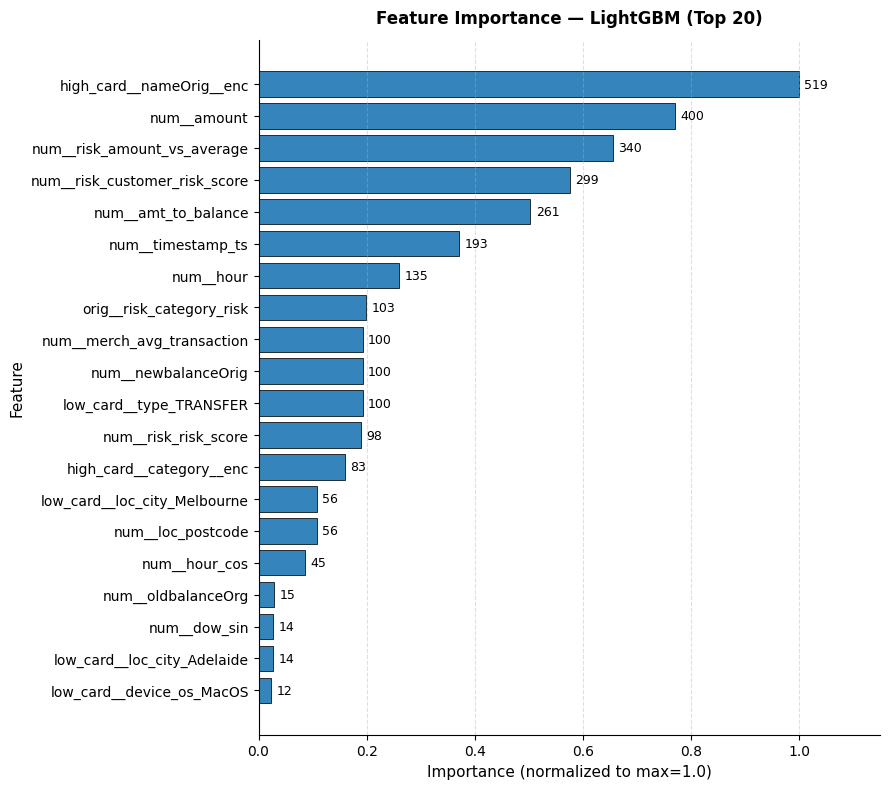

In [731]:
plot_feature_importance(feature_importances["cat"], "CatBoost", top_n=20)
plot_feature_importance(feature_importances["xg"], "XGBoost", top_n=20)
plot_feature_importance(feature_importances["ligh"], "LightGBM", top_n=20)


## Permutation importance

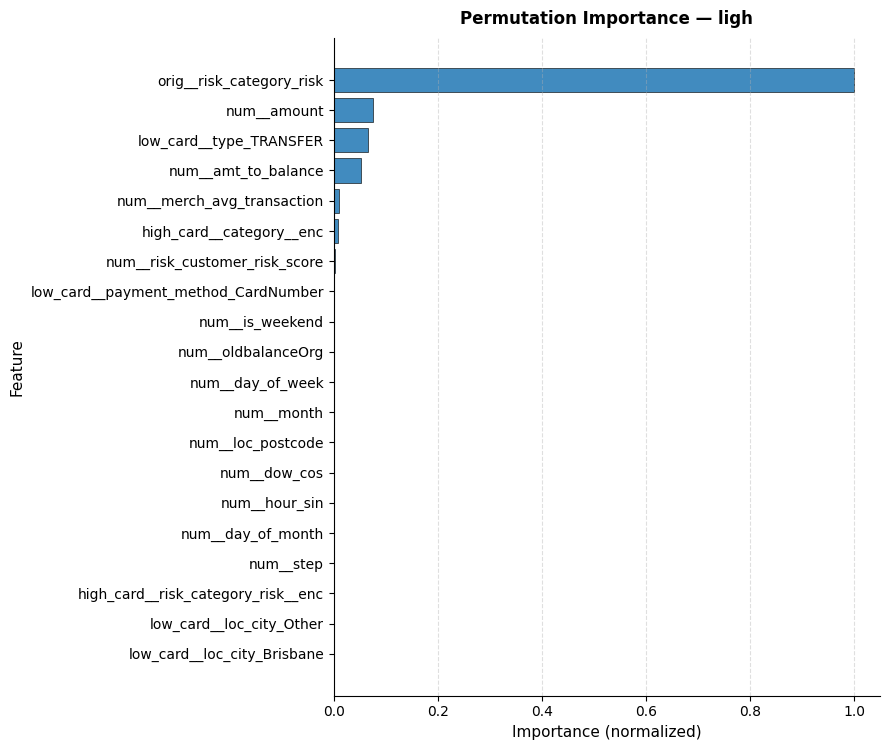

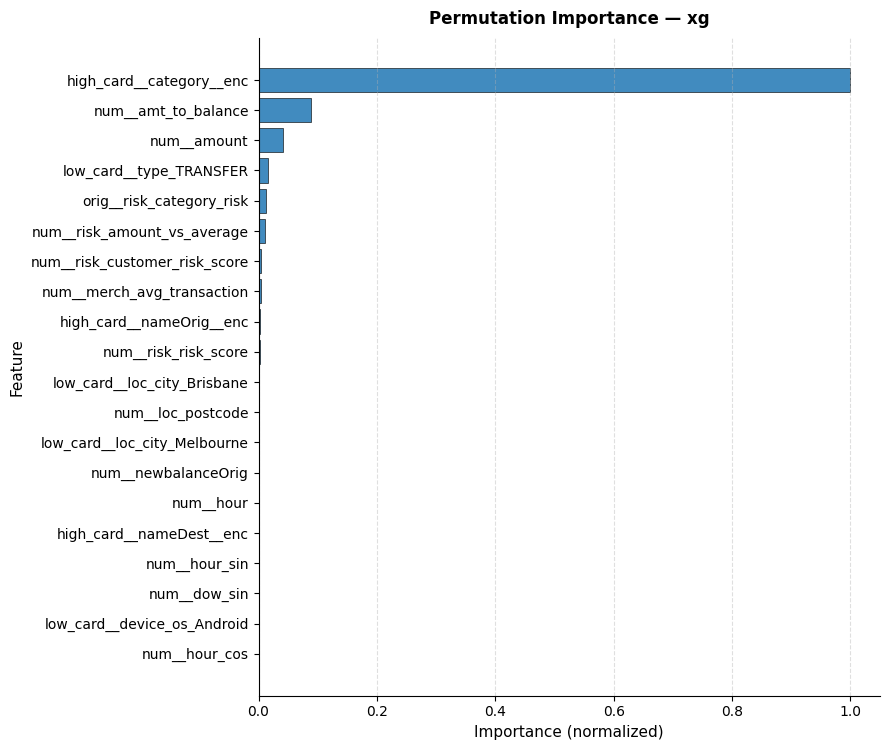

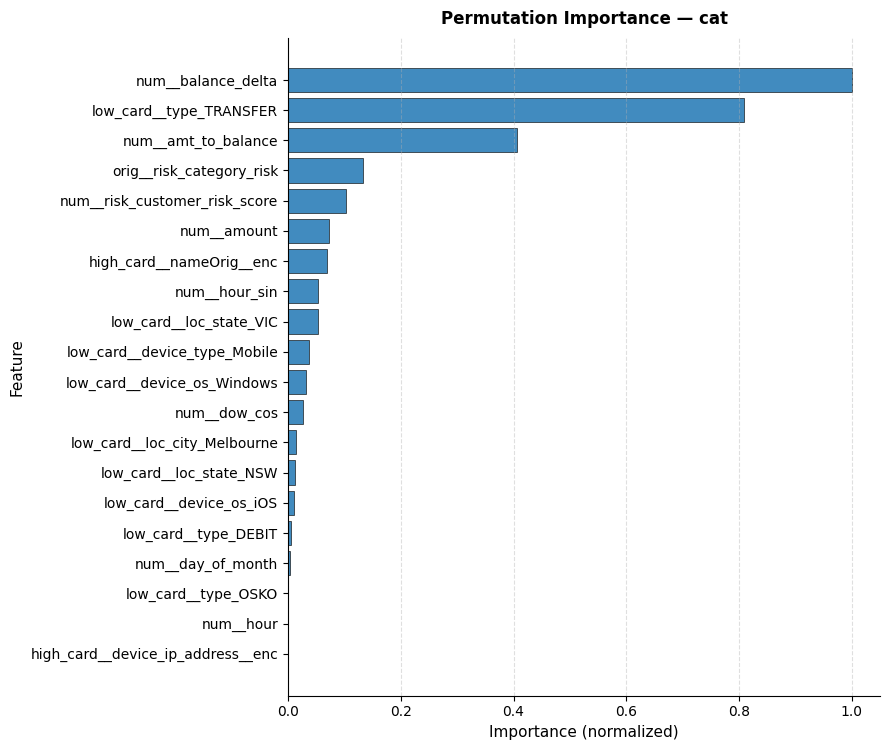

In [732]:
plot_permutation_importance_all(fi_perm, top_n=20)


## SHAP

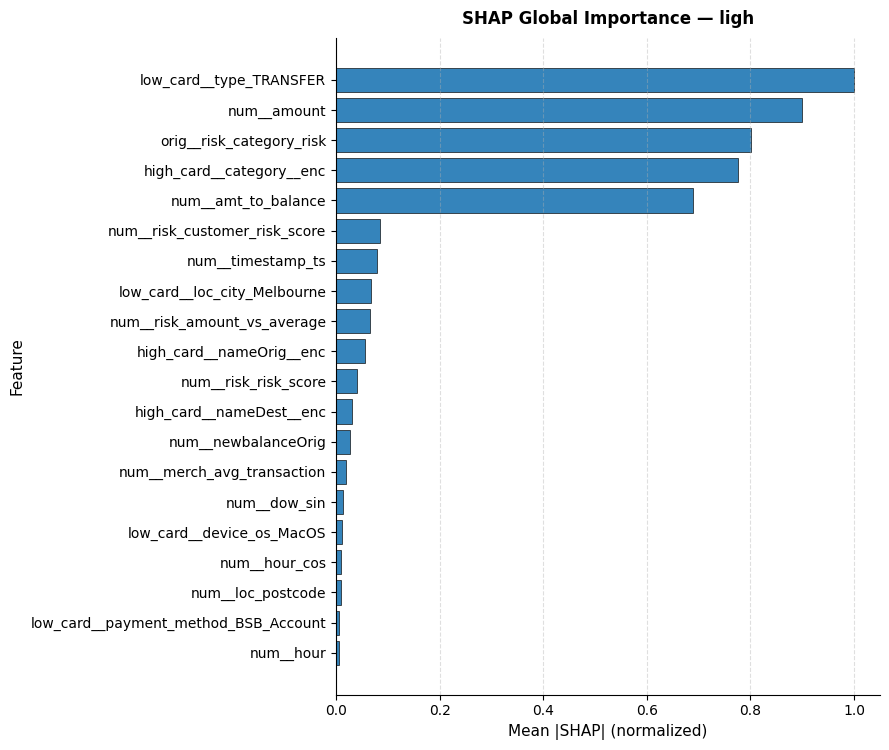

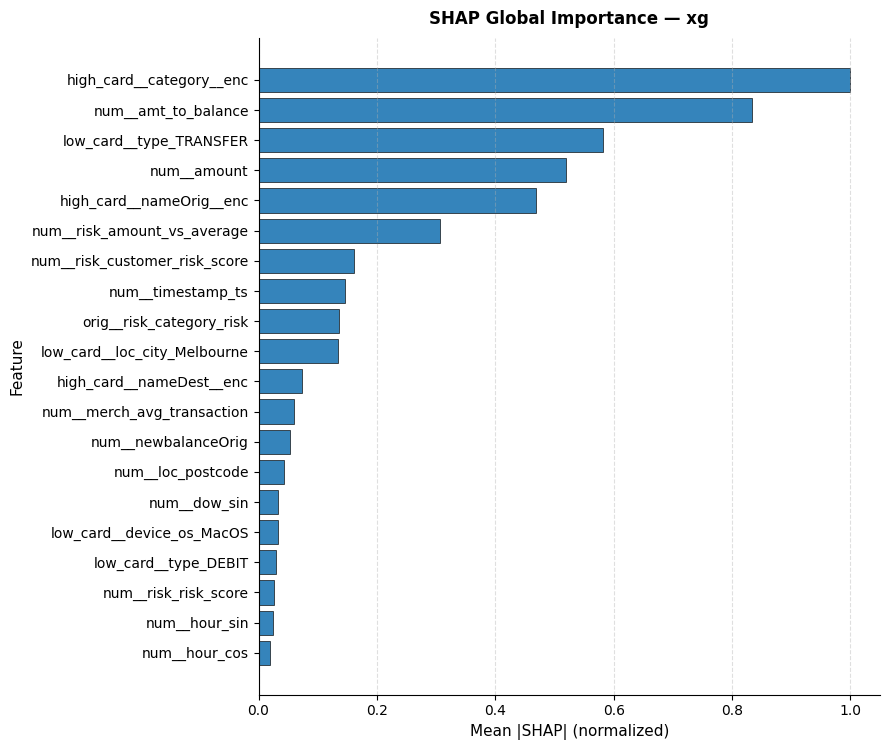

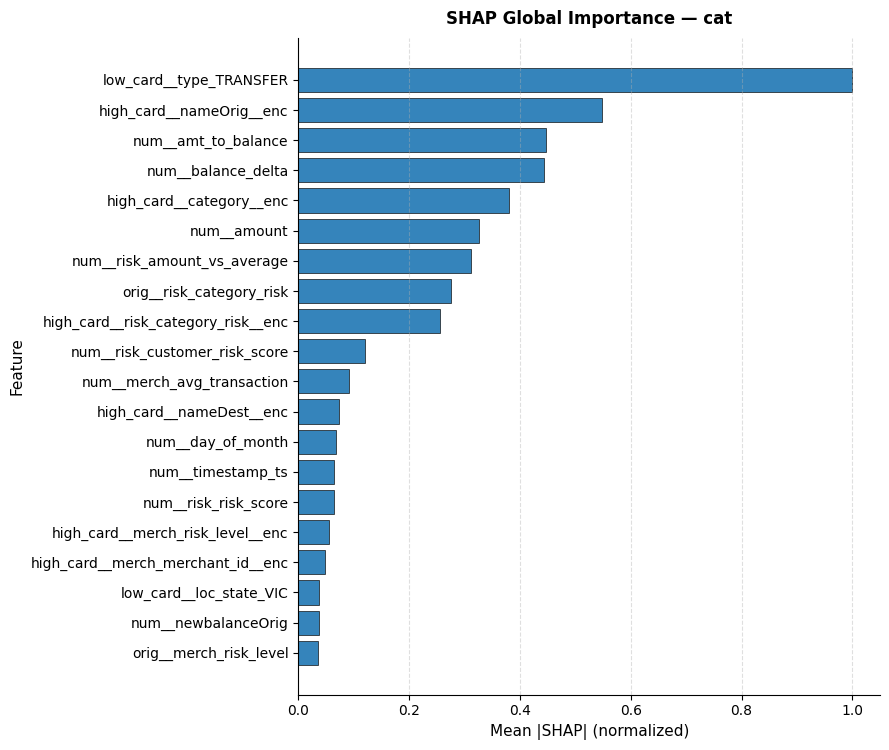

In [733]:
plot_shap_global_importance_all(shap_df, top_n=20)

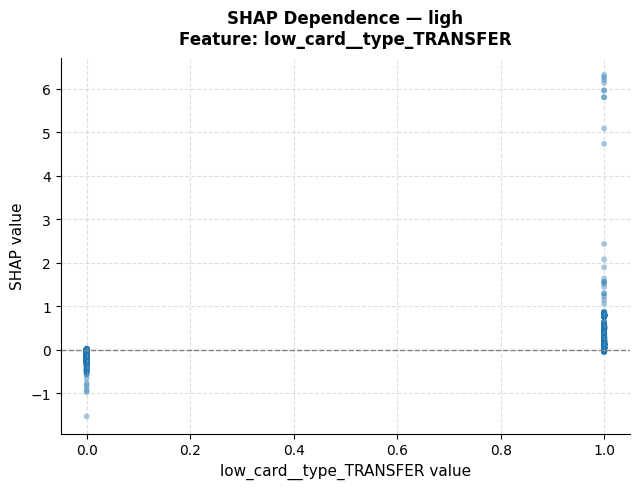

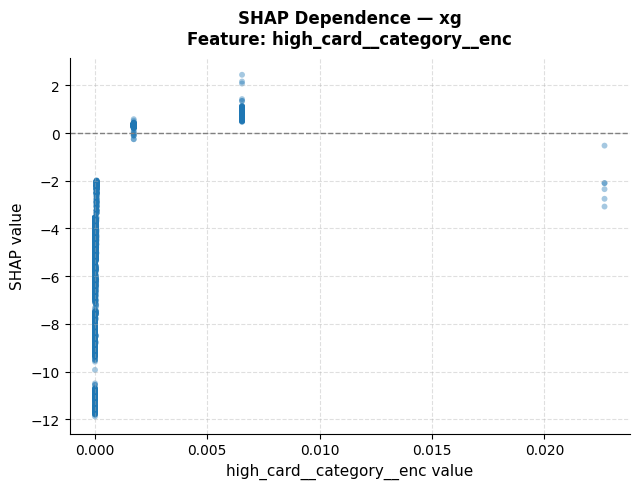

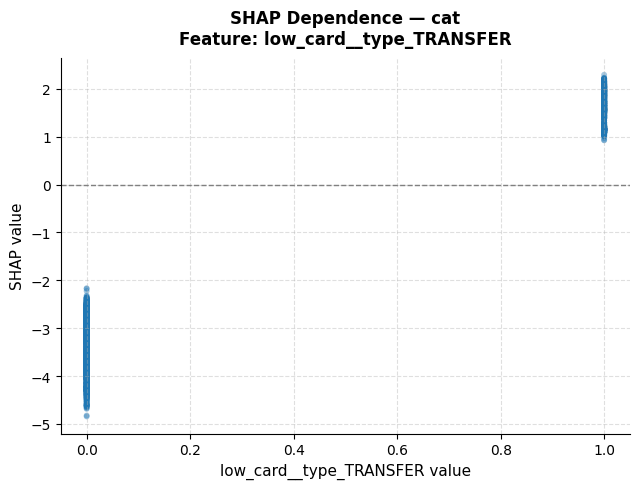

In [734]:
plot_shap_top_feature_all(shap_df, X_test)

# Creating the final ensemble

1. Optuna cat, xgb, ligh
2. Ensemble from models
3. Threshold

## Optuna

In [808]:
N_pos = (y_train == 1).sum()
N_neg = (y_train == 0).sum()

scale_pos_weight = N_neg / N_pos

In [809]:
def suggest_params(trial, name):
    if name == "cat":
        params = {
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 3, 30, log=True),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),
        }

    elif name == "xg":
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "min_child_weight": trial.suggest_float("min_child_weight", 10.0, 50.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 2.0, 50.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 5.0, log=True),
            "max_delta_step": trial.suggest_int("max_delta_step", 0, 5),
        }

    elif name == "ligh":
        params = {
            "max_depth": trial.suggest_int("max_depth", 4, 10),
            "num_leaves": trial.suggest_int("num_leaves", 16, 96),
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        }
    else:
        raise ValueError(f"Unknown model name: {name}")

    return params


In [810]:
def build_model(name, params, scale_pos_weight):
    if name == "cat":
        return CatBoostClassifier(
            eval_metric="PRAUC",
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            iterations=3000,
            early_stopping_rounds=200,
            verbose=False,
            **params,
        )

    if name == "xg":
        return XGBClassifier(
            eval_metric="aucpr",
            scale_pos_weight=scale_pos_weight,
            n_jobs=-1,
            early_stopping_rounds=300,
            random_state=42,
            use_label_encoder=False,
            verbosity=0,
            **params,
        )

    if name == "ligh":
        return LGBMClassifier(
            class_weight="balanced",
            n_jobs=-1,
            random_state=42,
            verbose=-1,
            **params,
        )

    raise ValueError(f"Unknown model name: {name}")


def make_objective(name):
    def objective(trial):
        params = suggest_params(trial, name)
        model = build_model(name, params, scale_pos_weight)

        fit_kwargs = {
            "X": X_train,
            "y": y_train,
            "eval_set": [(X_val, y_val)],
        }

        if name == "xg":
            fit_kwargs["verbose"] = False

        model.fit(**fit_kwargs)

        y_val_pred = model.predict_proba(X_val)[:, 1]
        score = average_precision_score(y_val, y_val_pred)

        if not (0.0 < score < 1.0):
            return 0.0

        return score

    return objective

In [811]:
best_params = {}

for name in base_models.keys():
    print(f"=== OPTUNA TUNING | {name.upper()} ===")

    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=10,
        ),
    )

    study.optimize(
        make_objective(name),
        n_trials=20,
        show_progress_bar=False,
    )

    best_params[name] = study.best_params

    print(f"Best PR-AUC: {study.best_value:.6f}")
    print(f"Best params: {study.best_params}")

[I 2025-12-14 19:56:11,051] A new study created in memory with name: no-name-f6b8f33a-60bd-4f47-b586-c2de0111ba90


=== OPTUNA TUNING | XG ===


[I 2025-12-14 19:56:11,982] Trial 0 finished with value: 0.9167719101323997 and parameters: {'max_depth': 5, 'min_child_weight': 48.02857225639664, 'gamma': 1.4639878836228102, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'reg_lambda': 3.3044636340245686, 'reg_alpha': 2.4496293433163567e-06, 'max_delta_step': 5}. Best is trial 0 with value: 0.9167719101323997.
[I 2025-12-14 19:56:12,962] Trial 1 finished with value: 0.9029267699267455 and parameters: {'max_depth': 7, 'min_child_weight': 38.32290311184182, 'gamma': 0.041168988591604894, 'subsample': 0.9909729556485983, 'colsample_bytree': 0.9497327922401265, 'reg_lambda': 3.961569997047637, 'reg_alpha': 1.6521139617131478e-05, 'max_delta_step': 1}. Best is trial 0 with value: 0.9167719101323997.
[I 2025-12-14 19:56:13,977] Trial 2 finished with value: 0.9180769541530376 and parameters: {'max_depth': 5, 'min_child_weight': 30.990257265289515, 'gamma': 0.8638900372842315, 'subsample': 0.7873687420594125, 'colsa

Best PR-AUC: 0.928772
Best params: {'max_depth': 9, 'min_child_weight': 16.03583540095653, 'gamma': 1.4429399827308957, 'subsample': 0.7489570583168446, 'colsample_bytree': 0.8073384140437887, 'reg_lambda': 6.004772226246664, 'reg_alpha': 0.0028972769266581463, 'max_delta_step': 5}
=== OPTUNA TUNING | CAT ===


[I 2025-12-14 19:56:37,712] Trial 0 finished with value: 0.922647960196606 and parameters: {'l2_leaf_reg': 7.106591851092235, 'min_data_in_leaf': 48}. Best is trial 0 with value: 0.922647960196606.
[I 2025-12-14 19:56:46,167] Trial 1 finished with value: 0.9221784205176169 and parameters: {'l2_leaf_reg': 16.185092900010684, 'min_data_in_leaf': 34}. Best is trial 0 with value: 0.922647960196606.
[I 2025-12-14 19:56:53,571] Trial 2 finished with value: 0.9254605424325706 and parameters: {'l2_leaf_reg': 4.296748115469076, 'min_data_in_leaf': 16}. Best is trial 2 with value: 0.9254605424325706.
[I 2025-12-14 19:57:00,622] Trial 3 finished with value: 0.9239461408934728 and parameters: {'l2_leaf_reg': 3.429295162893966, 'min_data_in_leaf': 45}. Best is trial 2 with value: 0.9254605424325706.
[I 2025-12-14 19:57:08,910] Trial 4 finished with value: 0.9210245884807653 and parameters: {'l2_leaf_reg': 11.973917635685037, 'min_data_in_leaf': 39}. Best is trial 2 with value: 0.9254605424325706.
[

Best PR-AUC: 0.926374
Best params: {'l2_leaf_reg': 8.110848199986004, 'min_data_in_leaf': 21}
=== OPTUNA TUNING | LIGH ===


[I 2025-12-14 19:59:00,241] Trial 0 finished with value: 0.923545805155662 and parameters: {'max_depth': 6, 'num_leaves': 93, 'subsample': 0.9195981825434215}. Best is trial 0 with value: 0.923545805155662.
[I 2025-12-14 19:59:00,846] Trial 1 finished with value: 0.9251217648447074 and parameters: {'max_depth': 8, 'num_leaves': 28, 'subsample': 0.7467983561008608}. Best is trial 1 with value: 0.9251217648447074.
[I 2025-12-14 19:59:01,274] Trial 2 finished with value: 0.9229171226957684 and parameters: {'max_depth': 4, 'num_leaves': 86, 'subsample': 0.8803345035229626}. Best is trial 1 with value: 0.9251217648447074.
[I 2025-12-14 19:59:01,770] Trial 3 finished with value: 0.9296927343701348 and parameters: {'max_depth': 8, 'num_leaves': 17, 'subsample': 0.9909729556485983}. Best is trial 3 with value: 0.9296927343701348.
[I 2025-12-14 19:59:02,445] Trial 4 finished with value: 0.9262823498015613 and parameters: {'max_depth': 9, 'num_leaves': 33, 'subsample': 0.7545474901621302}. Best 

Best PR-AUC: 0.929693
Best params: {'max_depth': 8, 'num_leaves': 17, 'subsample': 0.9909729556485983}


In [756]:
val_df

,model,roc_auc,recall_curve,pr_auc,f1_05
0,ligh,0.999909,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.962621,0.910180
1,cat,0.999341,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.946600,0.925926
2,xg,0.999593,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.933484,0.892857


In [812]:
cat_opt = build_model("cat", best_params["cat"], scale_pos_weight).fit(X_train,y_train, eval_set=[(X_val, y_val)])
xg_opt = build_model("xg", best_params["xg"], scale_pos_weight).fit(X_train,y_train, eval_set=[(X_val, y_val)], verbose=False)
ligh_opt = build_model("ligh", best_params["ligh"], scale_pos_weight).fit(X_train,y_train, eval_set=[(X_val, y_val)])

In [815]:
evaluate_binary_classifier(cat_opt, X_val, y_val)

{'roc_auc': 0.998425445822668,
 'pr_auc': 0.926374181896181,
 'f1': 0.7801857585139319,
 'precision_curve': array([0.00165109, 0.00165111, 0.00165113, ..., 1.        , 1.        ,
        1.        ], shape=(84188,)),
 'recall_curve': array([1.        , 1.        , 1.        , ..., 0.01438849, 0.00719424,
        0.        ], shape=(84188,)),
 'confusion_matrix': array([[83990,    58],
        [   13,   126]])}

## Ensemble

Add 3% to pr auc

In [783]:
def fit_meta_weights_logreg(y_val, scores_dict, C=0.5):
    keys = list(scores_dict.keys())
    X_meta = np.column_stack([scores_dict[k] for k in keys])

    lr = LogisticRegression(
        C=C,
        solver="lbfgs",
        max_iter=2000,
        class_weight="balanced",
    )
    lr.fit(X_meta, y_val)

    w = np.maximum(lr.coef_.ravel(), 0)
    w = w / (w.sum() + 1e-12)

    return dict(zip(keys, w)), lr

scores_dict = {
    "cat": cat_opt.predict_proba(X_val)[:, 1],
    "xg":  xg_opt.predict_proba(X_val)[:, 1],
    "ligh": ligh_opt.predict_proba(X_val)[:, 1]
}

weights, lr = fit_meta_weights_logreg(y_val, scores_dict)

/Users/artem/Documents/Projects/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/artem/Documents/Projects/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/artem/Documents/Projects/.venv/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept


In [784]:
weights

{'cat': np.float64(0.4843664332326904),
 'xg': np.float64(0.5156335667672619),
 'ligh': np.float64(0.0)}

In [ ]:
class ScoreEnsemble:
    def __init__(self, models: dict, weights: dict):
        self.models = models
        self.weights = weights

        assert set(models.keys()) == set(weights.keys())
        assert abs(sum(weights.values()) - 1.0) < 1e-6

    def predict_proba(self, X):
        score = np.zeros(len(X))

        for name, model in self.models.items():
            w = self.weights[name]
            s = model.predict_proba(X)[:, 1]
            score += w * s

        return np.column_stack([1 - score, score])

    def predict(self, X, threshold: float):
        score = self.predict_proba(X)[:, 1]
        return (score >= threshold).astype(int)

In [788]:
models = {
    "cat": cat_opt,
    "xg":  xg_opt,
    "ligh": ligh_opt,
}
ensemble = ScoreEnsemble(models, weights)

## Threshold

In [ ]:
def threshold_at_fpr(y_true, y_score, max_fpr=0.01):
    fpr, tpr, thr = roc_curve(y_true, y_score)
    # roc_curve возвращает thr по убыванию (обычно), но полагаться не будем
    idx = np.where(fpr <= max_fpr)[0]
    if len(idx) == 0:
        return 1.0, 0.0  # порог недостижим, FPR слишком мал
    j = idx[-1]  # максимальный tpr среди допустимых fpr обычно ближе к границе
    return thr[j], tpr[j]

thr, recall = threshold_at_fpr(y_val, ensemble.predict_proba(X_val)[:,1], max_fpr=0.0001)
thr

In [ ]:
y_pred = ensemble.predict(X_val, thr)

In [723]:
f1_score(y_val, y_pred)

0.9144981412639405